In [4]:
#if youre running on colab, run this line first to properly load the h5 files
# !pip install tables --upgrade

     |████████████████████████████████| 4.3 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 69.4 MB/s eta 0:00:01


In [1]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [116]:
#maybe downgrade?
np.__version__

'1.18.5'

In [30]:
#!pip install numpy --upgrade

  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4


# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [5]:
ds = CustomDataset('./storage/data_for_pointcloud_MNIST/training_ds.h5')

In [10]:
# ds = CustomDataset('training_ds.h5')

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

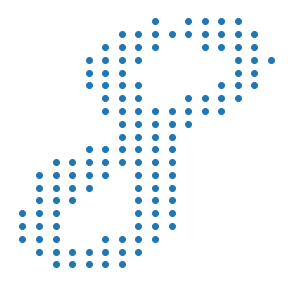

In [117]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

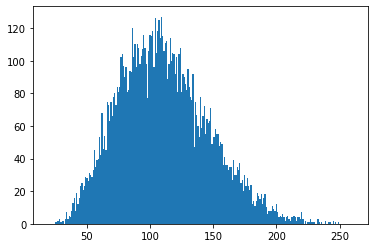

In [9]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [17]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        # hacky
        self.n_batches = 246
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch
        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [11]:
batch_size = 50
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
data_loader = DataLoader(ds, batch_sampler=batch_sampler)

In [60]:
for sample in data_loader:
    x,y = sample
    break

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [90]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

x1,x2 = linear_layer(  torch.rand((345,10)) ), linear_layer(  torch.rand((345,76,10)) )
x1.shape, x2.shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [128]:
torch.mean(x2,dim=1).shape

torch.Size([345, 5])

In [28]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape

torch.Size([42, 10])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [12]:
import pytorch_lightning as pl

In [13]:
path_to_training_data = './storage/data_for_pointcloud_MNIST/training_ds.h5'

In [14]:
path_to_validation_data = './storage/data_for_pointcloud_MNIST/valid_ds.h5'

In [15]:
NUM_CLASSES = 10

In [16]:
LOSS_FUNC = F.cross_entropy

In [123]:
# class ImageClassifier(nn.Module):
class DeepSet(pl.LightningModule):
    def __init__(self):        
        super().__init__()
        
        
        
        self.hidsize = 2048
        
        
        #MOD
        self.embedding = nn.Linear(2,self.hidsize).requires_grad_(False)
    
        
        
        self.classifier = nn.Sequential(
        
            
#             nn.Linear(2,hidsize)
            nn.ReLU(True),
            # try batchnorm, dropout
            #nn.Dropout(),
#             nn.Linear(hidsize, 4096),
#             nn.ReLU(True),
#             # MOD
#             nn.Dropout(),
            #num_classes = 10
            nn.Linear(self.hidsize, NUM_CLASSES),
        )
        
    def forward(self, batch):
        
#         self.hidsize = 2048
        
        
        
        out = self.embedding(batch)
        #MOD..also, requires_grad?
        out = torch.mean(out,dim=1).clone().detach().requires_grad_(False)
        
#         out = self.features(x)
        
#         # what does this accomplish 
#         out = self.avgpool(out)
#         out = torch.flatten(out,1)
        out = self.classifier(out)
        
        ##### pass through the rest of your model
        
        return out
    
    def train_dataloader(self):
        dataset_train = CustomDataset(path_to_training_data)
        batch_sampler = CustomBatchSampler(dataset_train.n_points, batch_size=50)
#         self.Ns = batch_sampler.entries
        return DataLoader(dataset_train,batch_sampler=batch_sampler,num_workers=4)

    def val_dataloader(self):
        dataset_val = CustomDataset(path_to_validation_data)
        batch_sampler_val = CustomBatchSampler(dataset_val.n_points,batch_size=50)
        return DataLoader(dataset_val,batch_sampler=batch_sampler_val,num_workers=4)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        
    
    def training_step(self,batch,batch_idx):
        print('batch_ix',batch_idx)
        print('batch',batch)
        minib,target = batch
        yhat = self(minib)
        print('yhat',yhat)
        print('target',target)
#         out = self.forward(minib)
        loss = LOSS_FUNC(yhat,target)
        print('loss',loss)
        
    
        # try this
        pred = yhat.argmax(dim=1, keepdim=True) #get ix of max log-proba
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct/len(minib)
        
        # add logging
        logs = {'train_loss': loss,'train_accuracy':accuracy}
        return {'loss': loss, 'log': logs}
#         return loss
    
    def validation_step(self,batch,batch_idx):
        minib, target = batch
#         out = self.forward(minib)
        yhat = self(minib)
        loss = LOSS_FUNC(yhat,target)
        
        pred = out.argmax(dim=1, keepdim=True) #get ix of max log-proba
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct/len(minib)
        
#         logs = {'train_loss': loss,'val_accuracy':accuracy}
#         return {'val_loss': loss, 'log': logs}
        
        return OrderedDict({'val_step_loss':loss, 'val_step_acc':accuracy})
        
    
    def validation_epoch_end(self, outputs):
        #TODO imbalanced given each batch is of a different size...
        avg_loss = torch.stack([x['val_step_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_step_acc'] for x in outputs]).mean()
        
        
        tqdm_dict = {'val_acc': avg_acc.item()}

        # show val_acc in progress bar but only log val_loss
        results = {
            'progress_bar': tqdm_dict,
            'log': {'val_acc': avg_acc.item(),
                    'val_loss': avg_loss.item()
                   }
        }
        return results
#         logs = {'val_loss':avg_loss}
#         return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}

In [119]:
x.shape

torch.Size([51, 87, 2])

In [ ]:
# from pytorch_lightning.callbacks import Callback

# class MyPrintingCallback(Callback):

#     def on_init_start(self, trainer):
#         print('Starting to init trainer!')

#     def on_init_end(self, trainer):
#         print('Trainer is init now')

#     def on_train_end(self, trainer, pl_module):
#         print('do something when training ends')

In [ ]:
# trainer = Trainer(callbacks=[MyPrintingCallback()])

In [124]:
net = DeepSet()

In [32]:
experiment = 'deepsettest'

In [33]:
comet_logger = CometLogger(
    api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    workspace="ren-e1011",
    project_name="dl1010-a3", 
    experiment_name=experiment  
)

CometLogger will be initialized in online mode
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/dl1010-a3/5c63ddf0320c4217acc6334af5931080
COMET INFO:   Others:
COMET INFO:     Name : deepsettest
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: old comet version (3.1.9) detected. current: 3.1.11 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/dl1010-a3/e649bb912f92426bb6bf372a670c67b8



In [125]:
trainer = pl.Trainer(fast_dev_run=True)

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: True, used: False
No environment variable for node rank defined. Set as 0.


In [126]:
trainer.fit(net)


  | Name         | Type       | Params
----------------------------------------
0 | embedding    | Linear     | 6 K   
1 | classifier   | Sequential | 20 K  
2 | classifier.0 | ReLU       | 0     
3 | classifier.1 | Linear     | 20 K  


batch_ix 0
batch [tensor([[[ 0.0000,  0.1429],
         [ 0.0000,  0.6429],
         [ 0.0000, -0.5714],
         [ 0.0000, -0.6429],
         [-0.0714, -0.4286],
         [ 0.0000,  0.0714],
         [ 0.0714,  0.3571],
         [-0.1429, -0.3571],
         [ 0.0714,  0.2857],
         [ 0.0000, -0.2143],
         [-0.0714,  0.0714],
         [ 0.0000,  0.7143],
         [ 0.0714,  0.2143],
         [ 0.0000,  0.4286],
         [-0.0714, -0.5000],
         [-0.0714, -0.5714],
         [-0.0714, -0.1429],
         [ 0.0000,  0.2857],
         [ 0.0000,  0.3571],
         [ 0.0000,  0.2143],
         [-0.1429, -0.2857],
         [ 0.0000, -0.0714],
         [-0.0714,  0.0000],
         [-0.1429, -0.4286],
         [ 0.0000, -0.1429],
         [ 0.0000,  0.5714],
         [-0.0714, -0.2857],
         [ 0.0000,  0.0000],
         [-0.0714, -0.0714],
         [ 0.0000,  0.5000],
         [-0.1429, -0.5000],
         [-0.0714, -0.3571],
         [ 0.0714,  0.1429],
         [-0.0714, -0.642

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [21]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        
        prediction = net(x).data.numpy()
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [95]:
test_ds = CustomDataset('valid_ds.h5')
batch_size = 50
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

compute_accuracy(data_loader_test,net)